c:\Users\lucas\anaconda3\envs\TP2_ICV\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



=== Imagem 1 ===


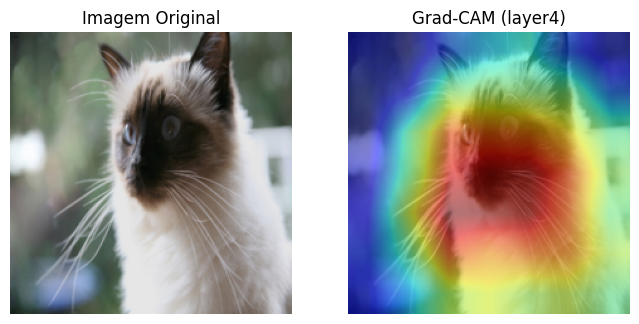

Feature map - layer1:


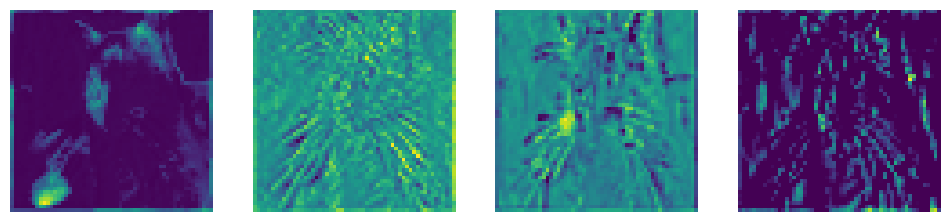

Feature map - layer2:


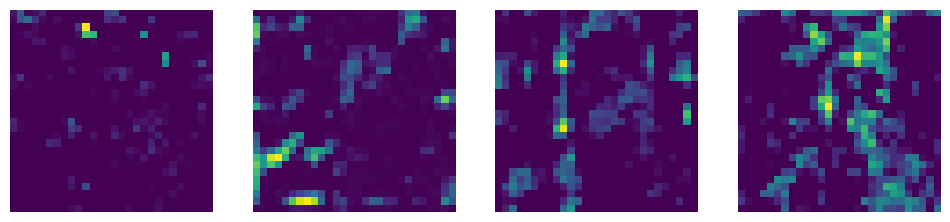

Feature map - layer3:


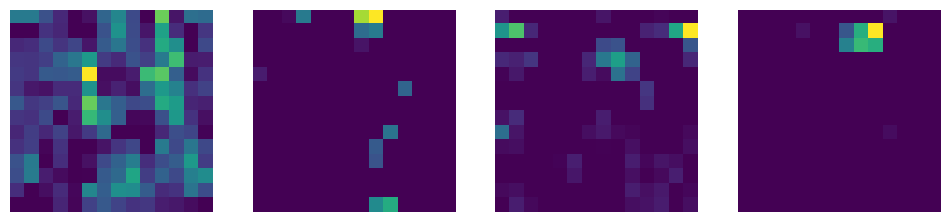

Feature map - layer4:


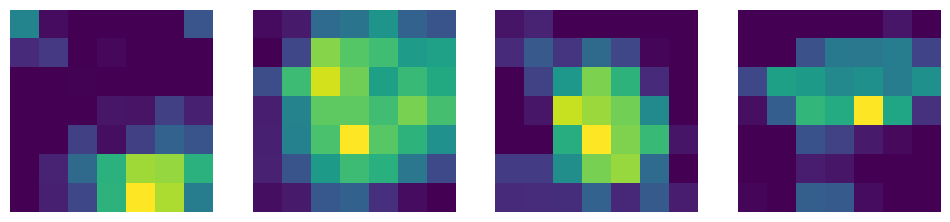


=== Imagem 2 ===


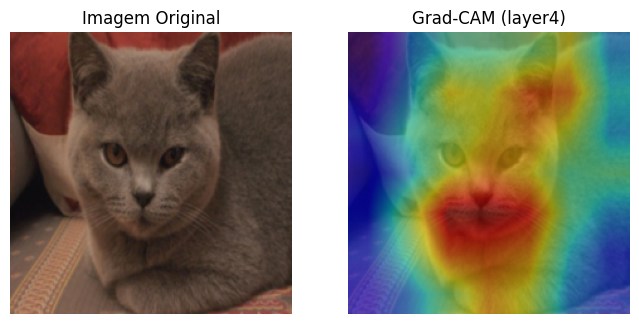

Feature map - layer1:


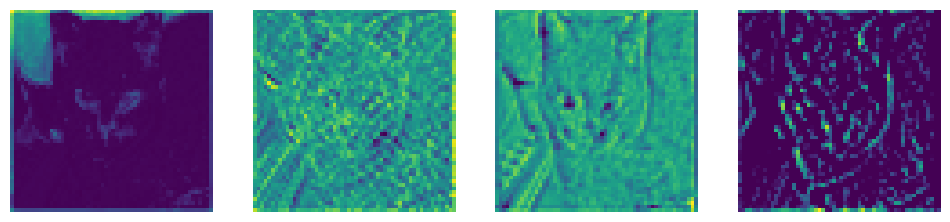

Feature map - layer2:


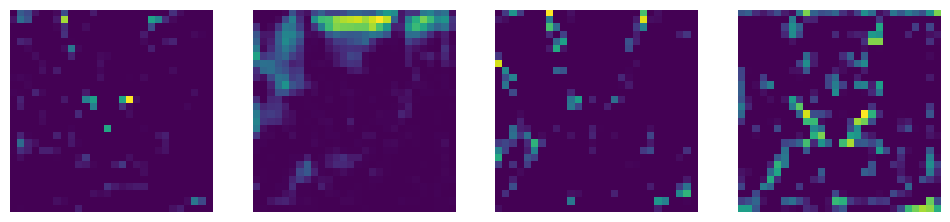

Feature map - layer3:


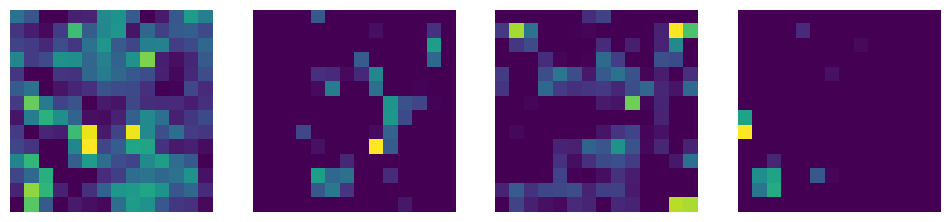

Feature map - layer4:


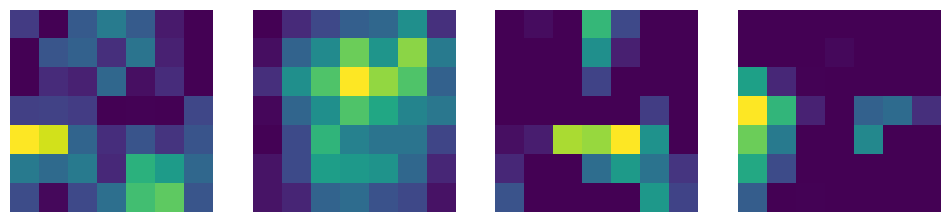


=== Imagem 3 ===


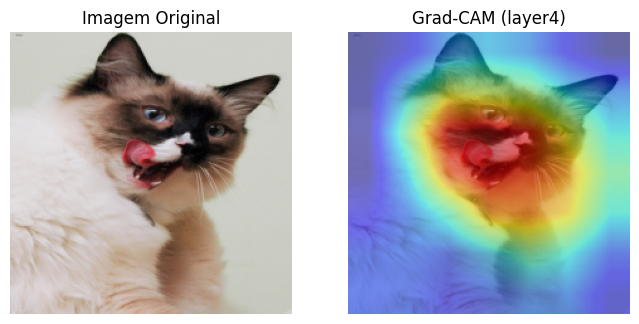

Feature map - layer1:


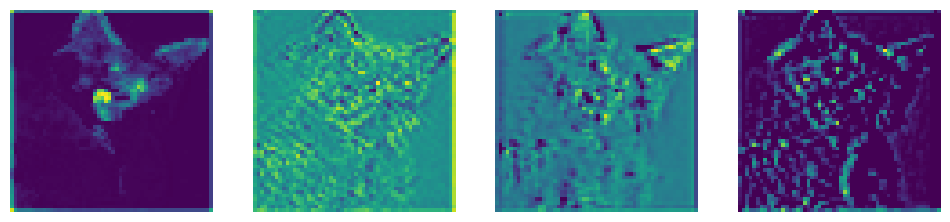

Feature map - layer2:


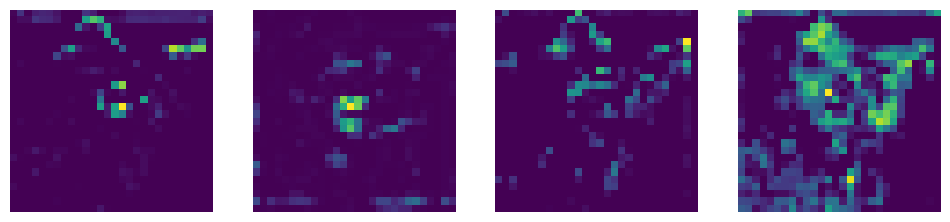

Feature map - layer3:


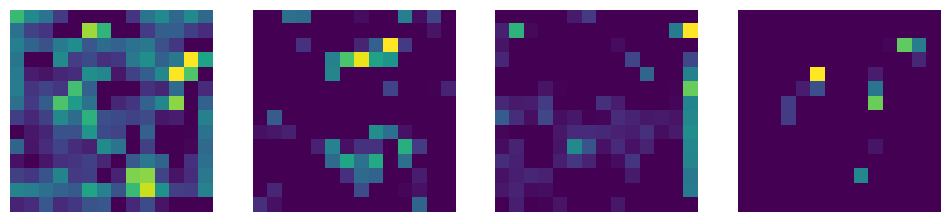

Feature map - layer4:


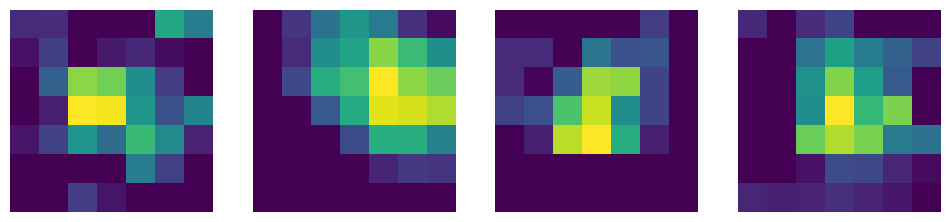


=== Imagem 4 ===


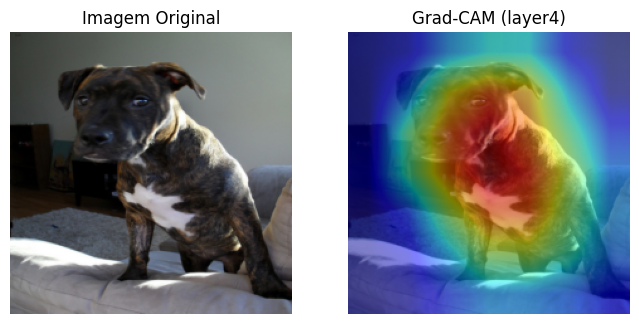

Feature map - layer1:


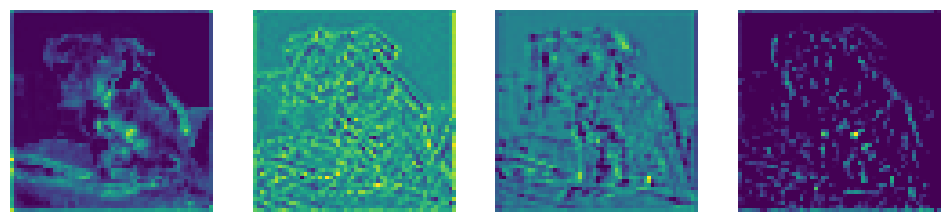

Feature map - layer2:


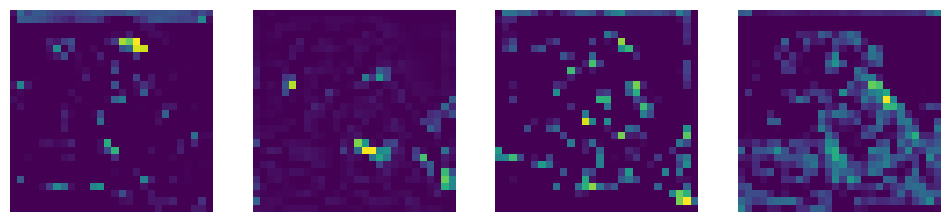

Feature map - layer3:


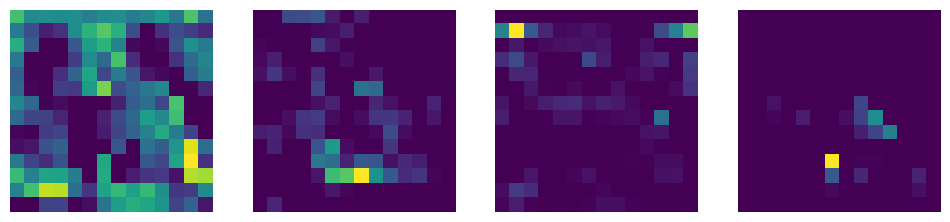

Feature map - layer4:


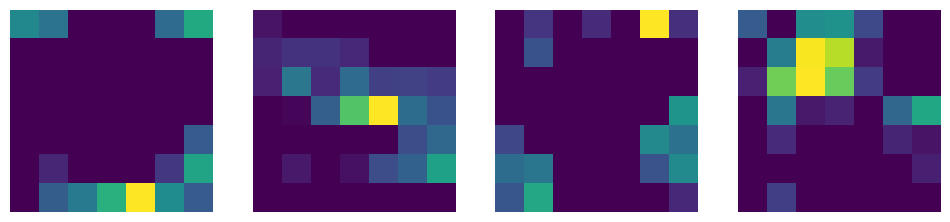


=== Imagem 5 ===


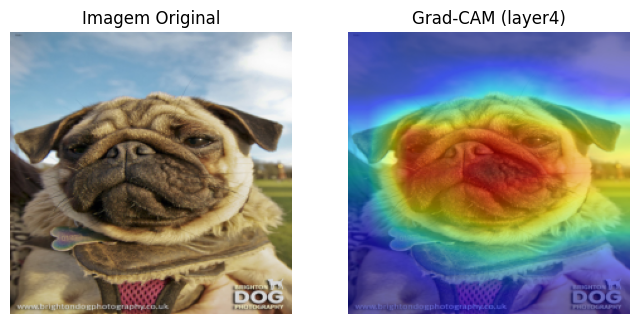

Feature map - layer1:


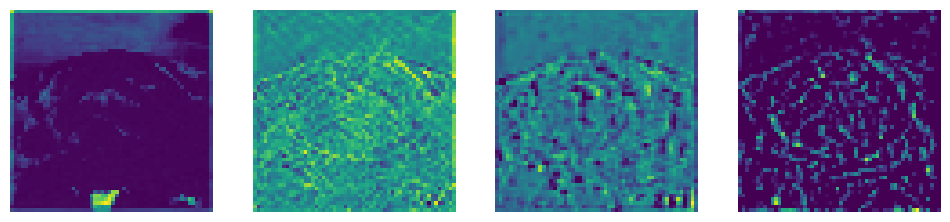

Feature map - layer2:


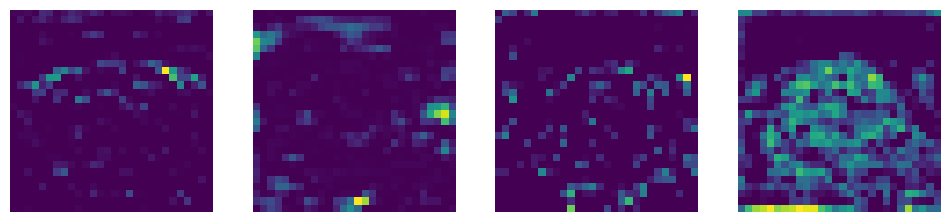

Feature map - layer3:


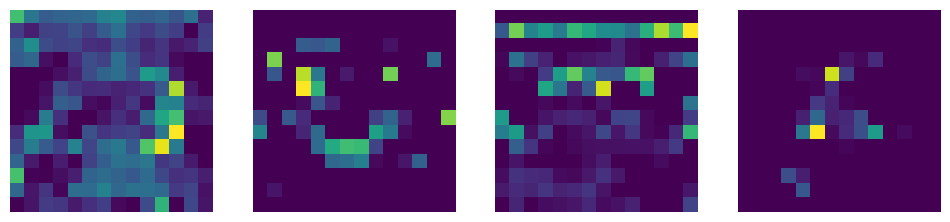

Feature map - layer4:


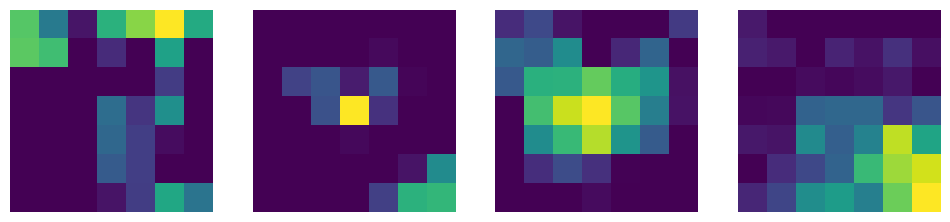

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet50
import torch.nn.functional as F
import io
import requests
import zipfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomOxfordDataset(Dataset):
    def __init__(self, images_dir, csv_file, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = int(self.annotations.iloc[idx, 1])
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# --- URLs raw do GitHub ---
zip_url = "https://github.com/Lucas-Junqueira/Pratica_IA/raw/refs/heads/main/oxford_subset/images_zip.zip"
csv_url = "https://github.com/Lucas-Junqueira/Pratica_IA/raw/main/oxford_subset/labels/labels.csv"

# --- Ler CSV diretamente ---
labels_df = pd.read_csv(csv_url)

# --- Baixar ZIP e carregar imagens em memória ---
response = requests.get(zip_url)
zip_bytes = io.BytesIO(response.content)

with zipfile.ZipFile(zip_bytes, 'r') as archive:
    images_dict = {}
    for name in archive.namelist():
        if name.lower().endswith(('.jpg', '.png')):
            filename = name.split('/')[-1]  # pega só o nome
            images_dict[filename] = archive.read(name)

# --- Dataset customizado ---
class InMemoryZipDataset(Dataset):
    def __init__(self, images_dict, labels_df, transform=None):
        self.images_dict = images_dict
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_name = row["filename"]
        label = int(row["label"])

        # Abrir imagem direto dos bytes
        image = Image.open(io.BytesIO(self.images_dict[img_name])).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# --- Transformações ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --- Dataset e DataLoader ---
dataset = InMemoryZipDataset(images_dict, labels_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# --- Modelo ResNet50 pré-treinado ---
model = resnet50(weights="IMAGENET1K_V1")
model.eval()

# --- Captura dos feature maps ---
feature_maps = {}
def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))

# --- Funções auxiliares ---
def show_image(img, ax=None):
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    if ax is None:
        plt.imshow(img)
        plt.axis("off")
    else:
        ax.imshow(img)
        ax.axis("off")

def show_feature_map(fmap, num_channels=4):
    fmap = fmap.squeeze(0)  # remove batch
    channels = torch.linspace(0, fmap.shape[0]-1, steps=num_channels).long()
    fig, axes = plt.subplots(1, num_channels, figsize=(12, 4))
    for i, ax in enumerate(axes):
        ax.imshow(fmap[channels[i]].cpu().numpy(), cmap="viridis")
        ax.axis("off")
    plt.show()

# --- Grad-CAM ---
gradients = {}
activations = {}
def forward_hook(module, input, output):
    activations["value"] = output.detach()
def backward_hook(module, grad_in, grad_out):
    gradients["value"] = grad_out[0].detach()

target_layer = model.layer4[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

def generate_gradcam(image_tensor, class_idx=None):
    output = model(image_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    model.zero_grad()
    loss = output[0, class_idx]
    loss.backward()
    grads = gradients["value"]
    acts = activations["value"]
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * acts).sum(dim=1).squeeze()
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam.cpu().numpy()

def show_gradcam_on_image(img_tensor, cam, ax, alpha=0.5):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam_tensor, size=(img.shape[0], img.shape[1]), mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().numpy()
    heatmap = plt.cm.jet(cam_resized)[..., :3]
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)
    ax.imshow(overlay)
    ax.axis("off")

# --- Processar imagens do subset salvo ---
for idx, (image, label) in enumerate(dataloader):
    feature_maps.clear()
    _ = model(image)  # forward

    print(f"\n=== Imagem {idx+1} ===")

    cam = generate_gradcam(image)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    show_image(image[0], axes[0])
    axes[0].set_title("Imagem Original")
    show_gradcam_on_image(image[0], cam, axes[1])
    axes[1].set_title("Grad-CAM (layer4)")
    plt.show()

    for name, fmap in feature_maps.items():
        print(f"Feature map - {name}:")
        show_feature_map(fmap, num_channels=4)
